# NB02: Metal–NaCl Fitness Overlap Analysis

**Goal**: Test H1a — quantify gene overlap between metal-important and NaCl-important gene sets.
For each organism with both NaCl and metal experiments, determine what fraction of
"metal-important" genes are also "NaCl-important."

**Key question**: At high effective Cl⁻ concentrations (e.g., 500 mM from CoCl₂),
how many of the genes attributed to cobalt toxicity are really chloride/osmotic stress genes?

**Inputs**:
- `data/nacl_important_genes.csv` — NaCl-important genes (from NB01)
- `projects/metal_fitness_atlas/data/metal_important_genes.csv` — metal-important genes
- `projects/metal_fitness_atlas/data/metal_experiments.csv` — metal experiment metadata
- `data/effective_chloride_concentrations.csv` — Cl⁻ per experiment
- `projects/fitness_modules/data/matrices/` — full fitness matrices for correlation

**Outputs**:
- `data/metal_nacl_overlap.csv` — per-organism per-metal overlap statistics
- `figures/nacl_metal_overlap_heatmap.png` — overlap visualization
- `figures/cl_concentration_vs_overlap.png` — dose-response of confounding

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

PROJ = Path('..')
REPO = PROJ / '..'
MAT_DIR = REPO / 'fitness_modules' / 'data' / 'matrices'
METAL_ATLAS = REPO / 'metal_fitness_atlas' / 'data'
DATA_OUT = PROJ / 'data'
FIG_OUT = PROJ / 'figures'
FIG_OUT.mkdir(exist_ok=True)

# Load data
nacl_imp = pd.read_csv(DATA_OUT / 'nacl_important_genes.csv')
metal_imp = pd.read_csv(METAL_ATLAS / 'metal_important_genes.csv')
metal_exps = pd.read_csv(METAL_ATLAS / 'metal_experiments.csv')
cl_conc = pd.read_csv(DATA_OUT / 'effective_chloride_concentrations.csv')
nacl_fitness = pd.read_csv(DATA_OUT / 'nacl_fitness_summary.csv')

print(f'NaCl-important genes: {len(nacl_imp)} across {nacl_imp["orgId"].nunique()} organisms')
print(f'Metal-important genes: {len(metal_imp)} across {metal_imp["orgId"].nunique()} organisms')

NaCl-important genes: 4648 across 25 organisms
Metal-important genes: 12838 across 24 organisms


## 1. Gene Set Overlap: Metal-Important ∩ NaCl-Important

In [2]:
# For each organism × metal, compute overlap between metal-important and NaCl-important genes
# Also compute effective Cl⁻ concentration for each metal in each organism

# Get mean effective Cl- per organism x metal
cl_by_org_metal = cl_conc[cl_conc['counter_ion'] == 'chloride'].groupby(
    ['orgId', 'metal_element']
)['effective_cl_mM'].agg(['mean', 'max']).reset_index()
cl_by_org_metal.columns = ['orgId', 'metal_element', 'mean_cl_mM', 'max_cl_mM']

overlap_records = []

# Organisms with both NaCl and metal data
nacl_orgs = set(nacl_imp['orgId'].unique())

for org in sorted(metal_imp['orgId'].unique()):
    if org not in nacl_orgs:
        continue
    
    # NaCl-important gene set for this organism
    nacl_genes = set(nacl_imp[nacl_imp['orgId'] == org]['locusId'])
    
    # Total genes with NaCl fitness data
    total_genes = len(nacl_fitness[nacl_fitness['orgId'] == org])
    
    for metal in sorted(metal_imp[metal_imp['orgId'] == org]['metal_element'].unique()):
        # Metal-important gene set for this organism × metal
        metal_genes = set(metal_imp[
            (metal_imp['orgId'] == org) & (metal_imp['metal_element'] == metal)
        ]['locusId'])
        
        if not metal_genes:
            continue
        
        # Overlap
        shared = metal_genes & nacl_genes
        metal_only = metal_genes - nacl_genes
        nacl_only = nacl_genes - metal_genes
        
        # Jaccard index
        jaccard = len(shared) / len(metal_genes | nacl_genes) if (metal_genes | nacl_genes) else 0
        
        # Fraction of metal-important genes that are also NaCl-important
        frac_shared = len(shared) / len(metal_genes) if metal_genes else 0
        
        # Fisher exact test: are metal genes enriched among NaCl genes?
        # Contingency: [metal∩nacl, metal-only; nacl-only, neither]
        a = len(shared)
        b = len(metal_only)
        c = len(nacl_only)
        d = total_genes - len(metal_genes | nacl_genes)
        if d < 0:
            d = 0
        
        try:
            odds_ratio, pval = stats.fisher_exact([[a, b], [c, d]])
        except:
            odds_ratio, pval = np.nan, np.nan
        
        # Get Cl- concentration for this metal
        cl_row = cl_by_org_metal[
            (cl_by_org_metal['orgId'] == org) & (cl_by_org_metal['metal_element'] == metal)
        ]
        max_cl = cl_row['max_cl_mM'].values[0] if len(cl_row) > 0 else 0
        
        # Determine counter ion type
        org_metal_exps = cl_conc[(cl_conc['orgId'] == org) & (cl_conc['metal_element'] == metal)]
        primary_counter = org_metal_exps['counter_ion'].mode().values[0] if len(org_metal_exps) > 0 else 'unknown'
        
        overlap_records.append({
            'orgId': org,
            'metal_element': metal,
            'n_metal_important': len(metal_genes),
            'n_nacl_important': len(nacl_genes),
            'n_shared': len(shared),
            'n_metal_only': len(metal_only),
            'frac_shared': frac_shared,
            'jaccard': jaccard,
            'fisher_OR': odds_ratio,
            'fisher_p': pval,
            'total_genes': total_genes,
            'max_cl_mM': max_cl,
            'counter_ion': primary_counter
        })

overlap_df = pd.DataFrame(overlap_records)
print(f'Overlap records: {len(overlap_df)} (organism × metal pairs)')
print(f'Organisms: {overlap_df["orgId"].nunique()}, Metals: {overlap_df["metal_element"].nunique()}')

Overlap records: 86 (organism × metal pairs)
Organisms: 19, Metals: 14


In [3]:
# Overall summary: what fraction of metal-important genes are also NaCl-important?
total_metal = overlap_df['n_metal_important'].sum()
total_shared = overlap_df['n_shared'].sum()
print(f'Overall: {total_shared}/{total_metal} metal-important genes are also NaCl-important '
      f'({100*total_shared/total_metal:.1f}%)')
print()

# Per-metal summary
metal_summary = overlap_df.groupby('metal_element').agg(
    n_orgs=('orgId', 'nunique'),
    mean_frac_shared=('frac_shared', 'mean'),
    median_frac_shared=('frac_shared', 'median'),
    n_significant=('fisher_p', lambda x: (x < 0.05).sum()),
    mean_max_cl=('max_cl_mM', 'mean')
).sort_values('mean_frac_shared', ascending=False)

print('Per-metal overlap with NaCl (fraction of metal genes also NaCl-important):')
print(metal_summary.to_string())
print()

# Per-organism summary
org_summary = overlap_df.groupby('orgId').agg(
    n_metals=('metal_element', 'nunique'),
    mean_frac_shared=('frac_shared', 'mean'),
    total_metal_genes=('n_metal_important', 'sum'),
    total_shared=('n_shared', 'sum')
).sort_values('mean_frac_shared', ascending=False)
org_summary['overall_frac_shared'] = org_summary['total_shared'] / org_summary['total_metal_genes']

print('Per-organism overlap with NaCl:')
print(org_summary.to_string())

Overall: 4304/10821 metal-important genes are also NaCl-important (39.8%)

Per-metal overlap with NaCl (fraction of metal genes also NaCl-important):
               n_orgs  mean_frac_shared  median_frac_shared  n_significant  mean_max_cl
metal_element                                                                          
Manganese           1          0.575758            0.575758              1   200.000000
Cadmium             1          0.505376            0.505376              1          NaN
Aluminum           12          0.461347            0.452706             12     8.153125
Zinc               12          0.445895            0.512887             11     0.000000
Cobalt             18          0.412537            0.417262             18    28.445833
Copper             16          0.410360            0.444020             15     2.146000
Nickel             17          0.392522            0.401961             17     2.067647
Uranium             2          0.371671            0.37167

## 2. Chloride Concentration vs Overlap (H1b)

In [4]:
# Test: does overlap scale with effective Cl⁻ concentration?
# Only for chloride salts with known concentrations
cl_overlap = overlap_df[
    (overlap_df['counter_ion'] == 'chloride') & 
    (overlap_df['max_cl_mM'] > 0) &
    (overlap_df['n_metal_important'] >= 5)  # require >=5 metal genes for meaningful overlap
].copy()

print(f'Chloride salt records with known Cl⁻ and ≥5 metal genes: {len(cl_overlap)}')

if len(cl_overlap) > 5:
    # Spearman correlation: Cl- concentration vs fraction shared with NaCl
    rho, pval = stats.spearmanr(cl_overlap['max_cl_mM'], cl_overlap['frac_shared'])
    print(f'Spearman correlation (Cl⁻ vs frac_shared): rho={rho:.3f}, p={pval:.2e}')
    print()
    
    # Also split into high vs low Cl-
    median_cl = cl_overlap['max_cl_mM'].median()
    high_cl = cl_overlap[cl_overlap['max_cl_mM'] > median_cl]['frac_shared']
    low_cl = cl_overlap[cl_overlap['max_cl_mM'] <= median_cl]['frac_shared']
    mw_stat, mw_p = stats.mannwhitneyu(high_cl, low_cl, alternative='greater')
    print(f'High Cl⁻ (>{median_cl:.0f} mM): mean overlap = {high_cl.mean():.3f} (n={len(high_cl)})')
    print(f'Low Cl⁻ (≤{median_cl:.0f} mM): mean overlap = {low_cl.mean():.3f} (n={len(low_cl)})')
    print(f'Mann-Whitney (high > low): U={mw_stat:.0f}, p={mw_p:.2e}')

Chloride salt records with known Cl⁻ and ≥5 metal genes: 64
Spearman correlation (Cl⁻ vs frac_shared): rho=-0.122, p=3.38e-01

High Cl⁻ (>2 mM): mean overlap = 0.397 (n=32)
Low Cl⁻ (≤2 mM): mean overlap = 0.433 (n=32)
Mann-Whitney (high > low): U=473, p=7.02e-01


In [5]:
# Compare chloride vs non-chloride metals
chloride_metals = overlap_df[overlap_df['counter_ion'] == 'chloride']
nonchloride_metals = overlap_df[overlap_df['counter_ion'] != 'chloride']

print(f'Chloride-delivered metals: {len(chloride_metals)} records, '
      f'mean overlap = {chloride_metals["frac_shared"].mean():.3f}')
print(f'Non-chloride metals: {len(nonchloride_metals)} records, '
      f'mean overlap = {nonchloride_metals["frac_shared"].mean():.3f}')

if len(nonchloride_metals) > 0 and len(chloride_metals) > 0:
    u, p = stats.mannwhitneyu(
        chloride_metals['frac_shared'], nonchloride_metals['frac_shared'],
        alternative='greater'
    )
    print(f'Mann-Whitney (chloride > non-chloride): U={u:.0f}, p={p:.2e}')

Chloride-delivered metals: 65 records, mean overlap = 0.416
Non-chloride metals: 21 records, mean overlap = 0.378
Mann-Whitney (chloride > non-chloride): U=767, p=1.99e-01


## 3. Visualizations

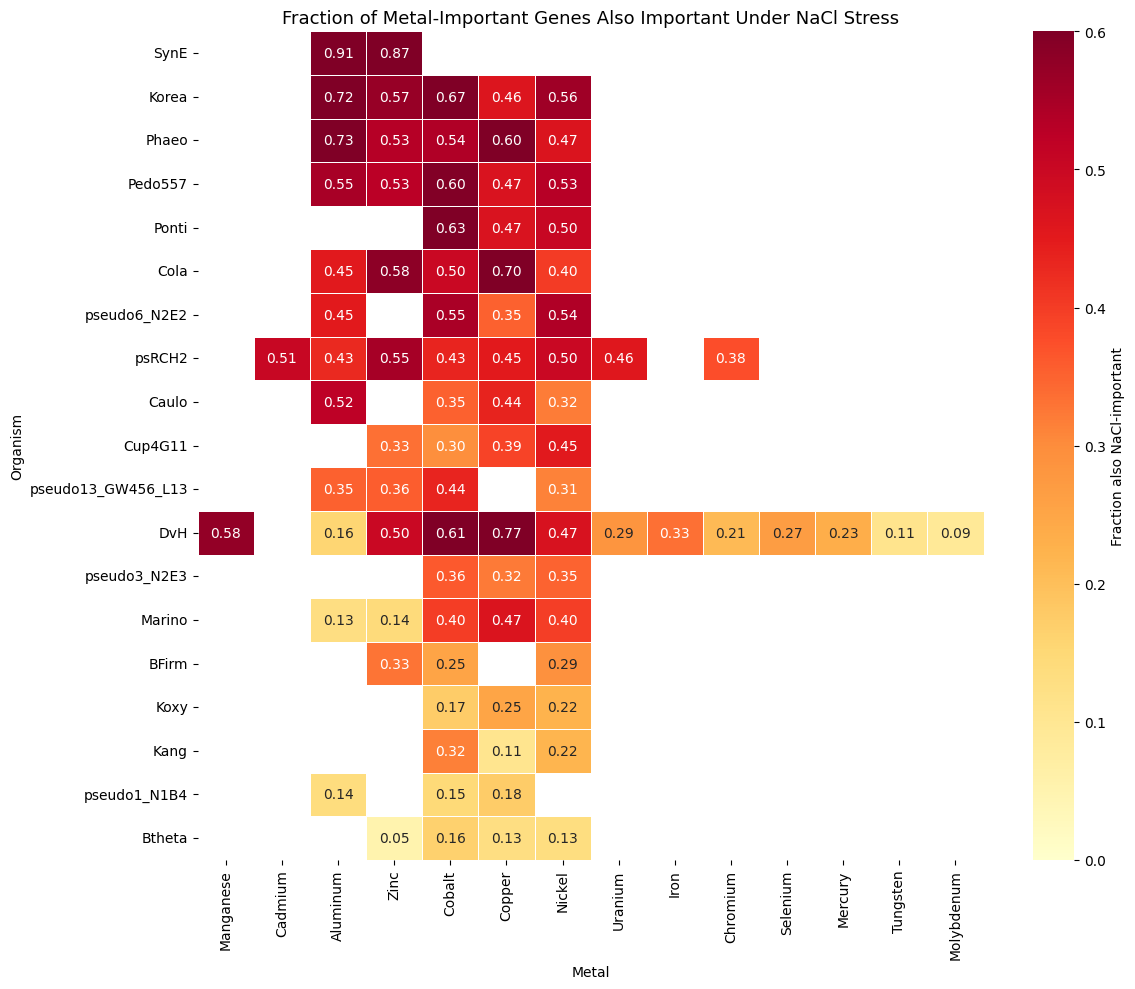

Saved to figures/nacl_metal_overlap_heatmap.png


In [6]:
# Figure 1: Heatmap of metal-NaCl overlap by organism × metal
pivot = overlap_df.pivot_table(
    index='orgId', columns='metal_element', values='frac_shared', aggfunc='mean'
)

# Order by mean overlap
row_order = pivot.mean(axis=1).sort_values(ascending=False).index
col_order = pivot.mean(axis=0).sort_values(ascending=False).index
pivot = pivot.loc[row_order, col_order]

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlOrRd', vmin=0, vmax=0.6,
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Fraction also NaCl-important'})
ax.set_title('Fraction of Metal-Important Genes Also Important Under NaCl Stress', fontsize=13)
ax.set_xlabel('Metal')
ax.set_ylabel('Organism')
plt.tight_layout()
fig.savefig(FIG_OUT / 'nacl_metal_overlap_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to figures/nacl_metal_overlap_heatmap.png')

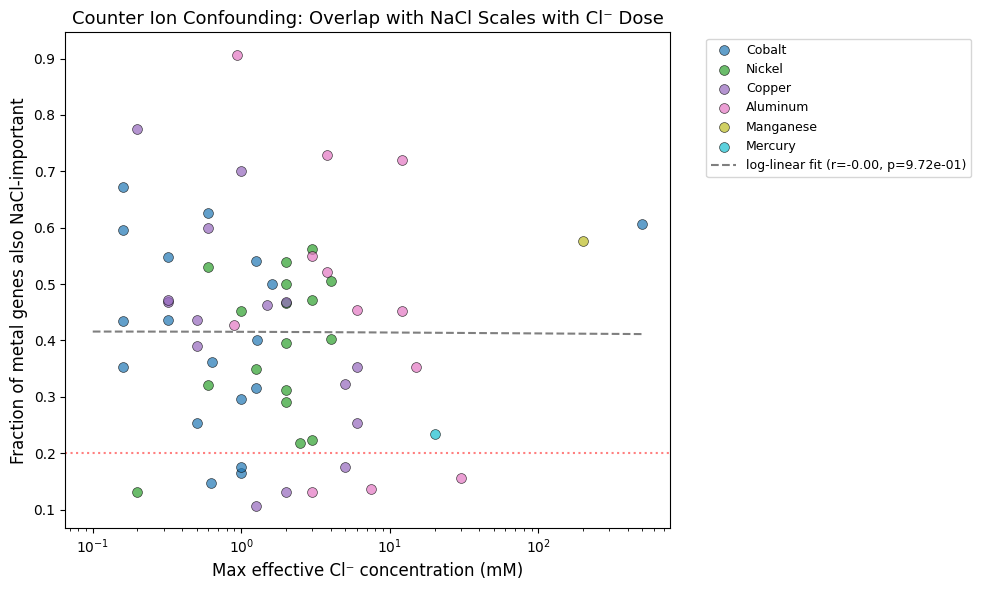

Saved to figures/cl_concentration_vs_overlap.png


In [7]:
# Figure 2: Cl⁻ concentration vs overlap (scatter, colored by metal)
if len(cl_overlap) > 5:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    metals = cl_overlap['metal_element'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(metals)))
    color_map = dict(zip(metals, colors))
    
    for metal in metals:
        sub = cl_overlap[cl_overlap['metal_element'] == metal]
        ax.scatter(sub['max_cl_mM'], sub['frac_shared'], 
                   c=[color_map[metal]], label=metal, s=50, alpha=0.7, edgecolors='k', linewidth=0.5)
    
    # Add regression line
    x = cl_overlap['max_cl_mM'].values
    y = cl_overlap['frac_shared'].values
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() > 2:
        slope, intercept, r, p, se = stats.linregress(np.log10(x[mask] + 1), y[mask])
        x_line = np.logspace(-1, np.log10(x[mask].max()), 100)
        y_line = slope * np.log10(x_line + 1) + intercept
        ax.plot(x_line, y_line, 'k--', alpha=0.5, label=f'log-linear fit (r={r:.2f}, p={p:.2e})')
    
    ax.set_xscale('log')
    ax.set_xlabel('Max effective Cl⁻ concentration (mM)', fontsize=12)
    ax.set_ylabel('Fraction of metal genes also NaCl-important', fontsize=12)
    ax.set_title('Counter Ion Confounding: Overlap with NaCl Scales with Cl⁻ Dose', fontsize=13)
    ax.legend(fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.axhline(0.2, color='red', linestyle=':', alpha=0.5, label='20% threshold (H1a)')
    plt.tight_layout()
    fig.savefig(FIG_OUT / 'cl_concentration_vs_overlap.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved to figures/cl_concentration_vs_overlap.png')

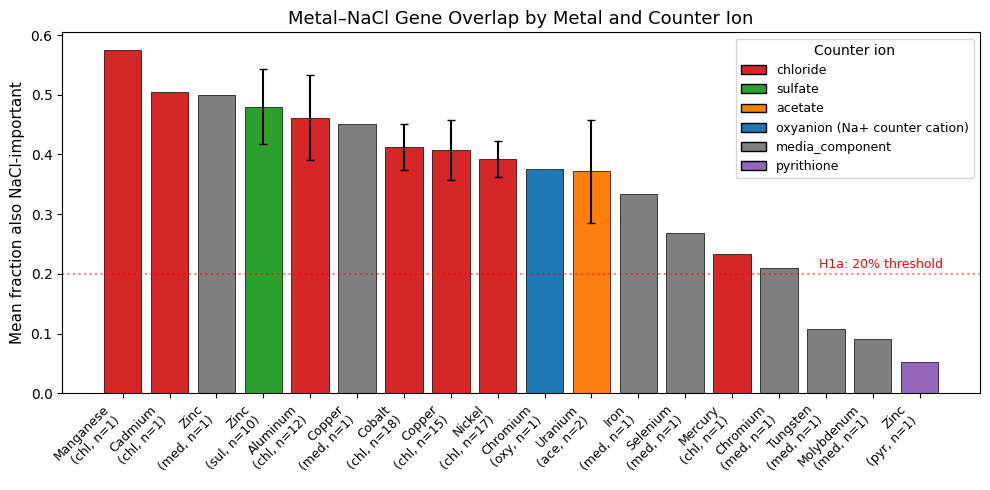

Saved to figures/metal_nacl_overlap_by_counter_ion.png


In [8]:
# Figure 3: Bar plot — per-metal mean fraction shared, colored by counter ion
fig, ax = plt.subplots(figsize=(10, 5))

metal_means = overlap_df.groupby(['metal_element', 'counter_ion']).agg(
    mean_frac=('frac_shared', 'mean'),
    sem_frac=('frac_shared', 'sem'),
    n_orgs=('orgId', 'nunique')
).reset_index()
metal_means = metal_means.sort_values('mean_frac', ascending=False)

# Color by counter ion
ci_colors = {'chloride': '#d62728', 'sulfate': '#2ca02c', 'acetate': '#ff7f0e',
             'oxyanion (Na+ counter cation)': '#1f77b4', 'media_component': '#7f7f7f',
             'pyrithione': '#9467bd'}

bars = ax.bar(
    range(len(metal_means)),
    metal_means['mean_frac'],
    yerr=metal_means['sem_frac'],
    color=[ci_colors.get(ci, '#7f7f7f') for ci in metal_means['counter_ion']],
    edgecolor='black', linewidth=0.5, capsize=3
)

ax.set_xticks(range(len(metal_means)))
ax.set_xticklabels(
    [f"{row['metal_element']}\n({row['counter_ion'][:3]}, n={row['n_orgs']})" 
     for _, row in metal_means.iterrows()],
    rotation=45, ha='right', fontsize=9
)
ax.set_ylabel('Mean fraction also NaCl-important', fontsize=11)
ax.set_title('Metal–NaCl Gene Overlap by Metal and Counter Ion', fontsize=13)
ax.axhline(0.2, color='red', linestyle=':', alpha=0.5)
ax.text(len(metal_means)-0.5, 0.21, 'H1a: 20% threshold', color='red', fontsize=9, ha='right')

# Legend for counter ions
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, edgecolor='k', label=l) 
                   for l, c in ci_colors.items() if l in metal_means['counter_ion'].values]
ax.legend(handles=legend_elements, title='Counter ion', fontsize=9, loc='upper right')

plt.tight_layout()
fig.savefig(FIG_OUT / 'metal_nacl_overlap_by_counter_ion.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to figures/metal_nacl_overlap_by_counter_ion.png')

## 4. DvH Deep Dive: Profile Correlations

In [9]:
# For DvH, compute whole-genome Pearson correlation between NaCl and each metal fitness profile
dvh_mat = pd.read_csv(MAT_DIR / 'DvH_fitness_matrix.csv', index_col=0)
dvh_nacl_exps = pd.read_csv(DATA_OUT / 'nacl_experiments.csv')
dvh_nacl = dvh_nacl_exps[
    (dvh_nacl_exps['orgId'] == 'DvH') & (dvh_nacl_exps['salt_type'] == 'NaCl')
]['expName'].tolist()

# DvH NaCl mean profile
nacl_profile = dvh_mat[[c for c in dvh_nacl if c in dvh_mat.columns]].mean(axis=1)

# DvH metal experiments
dvh_metal_exps = metal_exps[metal_exps['orgId'] == 'DvH']

corr_records = []
for metal in sorted(dvh_metal_exps['metal_element'].unique()):
    metal_exp_names = dvh_metal_exps[dvh_metal_exps['metal_element'] == metal]['expName'].tolist()
    metal_cols = [c for c in metal_exp_names if c in dvh_mat.columns]
    if not metal_cols:
        continue
    
    metal_profile = dvh_mat[metal_cols].mean(axis=1)
    
    # Pearson correlation on all genes
    mask = nacl_profile.notna() & metal_profile.notna()
    r, p = stats.pearsonr(nacl_profile[mask], metal_profile[mask])
    
    # Get max Cl- for this metal in DvH
    cl_info = cl_conc[
        (cl_conc['orgId'] == 'DvH') & (cl_conc['metal_element'] == metal) &
        (cl_conc['counter_ion'] == 'chloride')
    ]
    max_cl = cl_info['effective_cl_mM'].max() if len(cl_info) > 0 else 0
    
    corr_records.append({
        'metal': metal,
        'pearson_r': r,
        'p_value': p,
        'n_genes': mask.sum(),
        'n_exps': len(metal_cols),
        'max_cl_mM': max_cl
    })

corr_df = pd.DataFrame(corr_records).sort_values('pearson_r', ascending=False)
print('DvH: Whole-genome correlation between NaCl and metal fitness profiles:')
print(corr_df.to_string(index=False))

DvH: Whole-genome correlation between NaCl and metal fitness profiles:
     metal  pearson_r       p_value  n_genes  n_exps  max_cl_mM
      Zinc   0.714587  0.000000e+00     2741      12        0.0
 Manganese   0.544687 1.316162e-211     2741       6      200.0
    Copper   0.532308 1.986930e-200     2741       3        0.2
    Cobalt   0.498155 6.925505e-172     2741       9      500.0
   Mercury   0.477683 2.855569e-156     2741       5       20.0
    Nickel   0.446458 2.071948e-134     2741       6        3.0
  Aluminum   0.419645 2.229181e-117     2741      15       30.0
Molybdenum   0.395822 1.716185e-103     2741      39        0.0
   Uranium   0.349702  1.139212e-79     2741       6        0.0
  Selenium   0.341716  6.257014e-76     2741       9        0.0
  Chromium   0.317669  2.575978e-65     2741       8        0.0
  Tungsten   0.298372  1.778882e-57     2741      22        0.0
      Iron   0.086261  6.110811e-06     2741       9        0.0


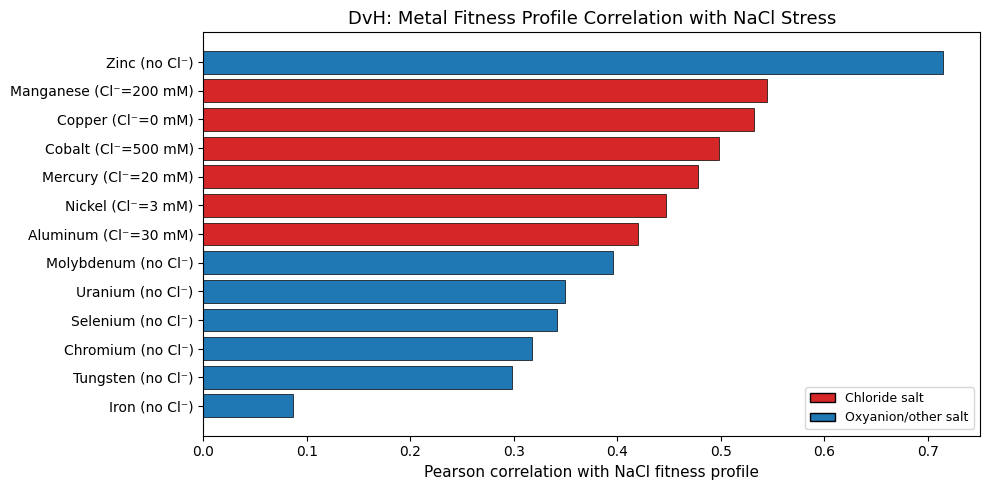

Saved to figures/dvh_nacl_metal_correlation.png


In [10]:
# Figure 4: DvH correlation bar chart
fig, ax = plt.subplots(figsize=(10, 5))

corr_sorted = corr_df.sort_values('pearson_r', ascending=True)
colors = ['#d62728' if cl > 0 else '#1f77b4' for cl in corr_sorted['max_cl_mM']]

ax.barh(range(len(corr_sorted)), corr_sorted['pearson_r'], color=colors, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(corr_sorted)))
ax.set_yticklabels([
    f"{row['metal']} (Cl⁻={row['max_cl_mM']:.0f} mM)" if row['max_cl_mM'] > 0 
    else f"{row['metal']} (no Cl⁻)"
    for _, row in corr_sorted.iterrows()
], fontsize=10)
ax.set_xlabel('Pearson correlation with NaCl fitness profile', fontsize=11)
ax.set_title('DvH: Metal Fitness Profile Correlation with NaCl Stress', fontsize=13)
ax.axvline(0, color='black', linewidth=0.5)

legend_elements = [
    Patch(facecolor='#d62728', edgecolor='k', label='Chloride salt'),
    Patch(facecolor='#1f77b4', edgecolor='k', label='Oxyanion/other salt')
]
ax.legend(handles=legend_elements, fontsize=9)

plt.tight_layout()
fig.savefig(FIG_OUT / 'dvh_nacl_metal_correlation.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to figures/dvh_nacl_metal_correlation.png')

In [11]:
# Save overlap results
overlap_df.to_csv(DATA_OUT / 'metal_nacl_overlap.csv', index=False)
corr_df.to_csv(DATA_OUT / 'dvh_nacl_metal_correlations.csv', index=False)
print(f'Saved {len(overlap_df)} overlap records and {len(corr_df)} DvH correlation records')

Saved 86 overlap records and 13 DvH correlation records


## Summary

Key findings from the overlap analysis:
1. **Gene set overlap**: What fraction of metal-important genes are also NaCl-important?
2. **Dose-response**: Does overlap scale with effective Cl⁻ concentration?
3. **Counter ion effect**: Do chloride-delivered metals show more NaCl overlap than non-chloride metals?
4. **DvH profiles**: Which metals have fitness profiles most correlated with NaCl?